In [1]:
import pickle
import tensorflow as tf
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import re, os
import random
from tqdm.auto import tqdm

tf.config.list_physical_devices('GPU')

2024-03-25 21:24:17.606977: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 21:24:17.607026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 21:24:17.634019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 21:24:17.692633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 21:24:18.628423: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# load pretrained tokenizer and short sequence data

from bpe_tokenizer import BPETokenizer
        
if __name__ == "__main__":

    with open('tokenizer.pkl','rb') as f:
        tokenizer = pickle.load(f)
        
with open('short-length pretraining data.pkl','rb') as f:
    data = pickle.load(f)

In [3]:
# function to create positional encoding weights

def positional_encoding(emb_dim,maxlen):
    pos = np.zeros((maxlen, emb_dim), dtype=np.float32)
    for p in range(maxlen):
        for i in range(emb_dim):
            if i % 2 == 0:
                angle = p / 10000 ** (2 * i / emb_dim)
                pos[p, i] = np.sin(angle)
            else:
                angle = p / 10000 ** (2 * i / emb_dim)
                pos[p, i] = np.cos(angle)
                
    return pos

<Axes: >

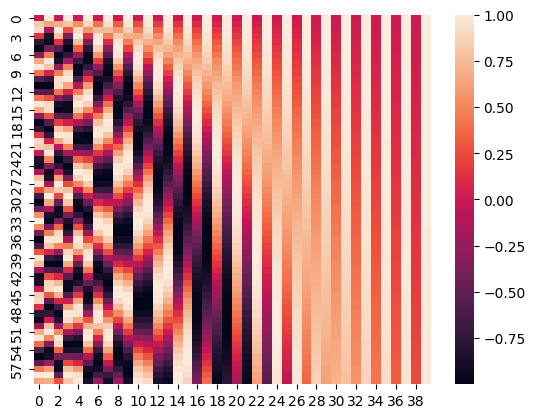

In [4]:
# define parameters

batch = 32
d_model = 128
n_heads = 8
units = d_model * 2
vocab_size = len(tokenizer.i2w)
maxlen = len(data['train']['masked_seq'][0])
n_layers = 4

encodings = positional_encoding(d_model,maxlen)

sb.heatmap(encodings[:,:40])

In [5]:
# build BERT for MLM task

import os
from bert import BERT

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)
    
reset_random_seeds()

seq = tf.keras.layers.Input((maxlen,),batch_size=batch)

bert_model = BERT(d_model=d_model, n_heads=n_heads, n_encoder_layer=n_layers, 
                  units=units, pos_weights=encodings, vocab_size=vocab_size) 

out = bert_model(seq)

mlm = tf.keras.layers.Dense(vocab_size,activation='softmax')(out)
model = tf.keras.Model(seq,mlm)

model.summary()




2024-03-25 21:24:25.445059: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 21:24:25.445267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 21:24:25.445398: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 60)]                0         
                                                                 
 bert (BERT)                 (32, 60, 128)             3144320   
                                                                 
 dense (Dense)               (32, 60, 20365)           2627085   
                                                                 
Total params: 5771405 (22.02 MB)
Trainable params: 5771405 (22.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# set positional embedding layer as non trainable

model.layers[1].layers[0].pos_emb.trainable = False

In [7]:
# numpy array to tensors

tmp = [(x,y) for x,y in zip(data['train']['masked_seq'],data['train']['seq'])]
np.random.shuffle(tmp)

data['train']['masked_seq'] = [x[0] for x in tmp]
data['train']['seq'] = [x[1] for x in tmp]

train = (data['train']['masked_seq'],data['train']['seq'])
val = (data['valid']['masked_seq'],data['valid']['seq'])

train = tf.data.Dataset.from_tensor_slices(train).batch(batch_size=batch,drop_remainder=True).shuffle(buffer_size=100)
val = tf.data.Dataset.from_tensor_slices(val).batch(batch_size=batch)

2024-03-25 21:25:08.170411: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


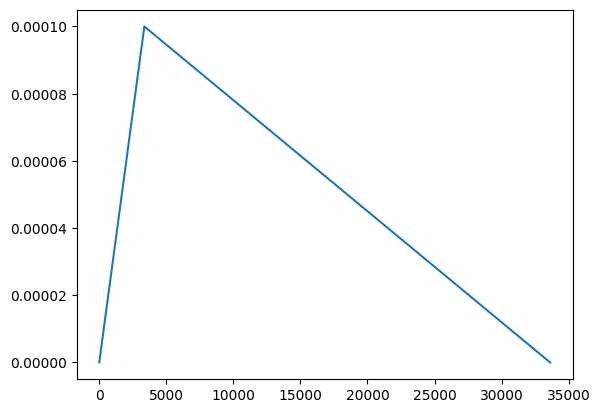

In [9]:
# linear warmup and decay lr scheduler class

class BERTLearningRateScheduler:
    
    def __init__(self,total_steps,init_lr=1e-4):
        self.total = total_steps
        self.warmup = total_steps // 10
        self.decay = total_steps - self.warmup
        self.init_lr = init_lr
        
    def __call__(self,step):
        if step <= self.warmup:
            lr = self.init_lr * (step / self.warmup)
        else:
            lr = self.init_lr * max(0,(self.total - step) / (max(1,self.decay)))
        return lr
    
total_steps = len(data['train']['seq']) // batch
total_steps = total_steps + 1 if len(data['train']['seq']) % batch != 0 else total_steps

lr_scheduler = BERTLearningRateScheduler(total_steps)
plt.plot([lr_scheduler(s) for s in range(1,total_steps)])

In [10]:
# initialize loss function and optimizer

mlm_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.AdamW(weight_decay=0.01)

test_mlm_x = data['valid']['masked_seq'][12]
test_mlm_y = data['valid']['seq'][12]


# function to see the pred and actual tokens over the training period
def predict_masked_tokens(test_mlm_x,test_mlm_y):
    seq = np.asarray([test_mlm_x])
    pred = model(seq)
    loss = mlm_loss_fn(test_mlm_y[np.newaxis:],pred,sample_weight=seq == 1).numpy()
    pred = np.argmax(pred,axis=-1)[0]
    
    idx = np.where(test_mlm_x==1)[0]

    t_tok = ' '.join([tokenizer.i2w[x] for x in test_mlm_y[idx]])
    p_tok = ' '.join([tokenizer.i2w[x] for x in pred[idx]])

    print('true tokens :',t_tok)
    print('pred tokens :',p_tok)
    print('sample mlm loss :',loss)
    
predict_masked_tokens(test_mlm_x,test_mlm_y)

true tokens : the coffee so bothering
pred tokens : dumped dumped dumped dumped
sample mlm loss : 0.6642578


2024-03-25 21:25:13.919768: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


In [11]:
# initialize train and val step function

@tf.function
def train_step(seq,mlm_y):
    with tf.GradientTape() as tape:
        mlm = model(seq,training=True)
        mlm_loss = mlm_loss_fn(mlm_y,mlm,sample_weight=seq == 1)
    weights = model.trainable_weights
    grads = tape.gradient(mlm_loss,weights)
    opt.apply_gradients(zip(grads,weights))
    return mlm_loss

@tf.function
def test_step(seq,mlm_y):
    mlm = model(seq,training=False)
    mlm_loss = mlm_loss_fn(mlm_y,mlm,sample_weight=seq == 1)
    return mlm_loss

epoch : 1/10


  0%|          | 0/33622 [00:00<?, ?it/s]

2024-03-25 21:25:18.819887: I external/local_xla/xla/service/service.cc:168] XLA service 0x768f6c0b6ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-25 21:25:18.819909: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-03-25 21:25:18.827924: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711382118.927568    4841 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


TRAINING
mlm loss : 0.4316993546822021
VALIDATION
mlm loss : 0.3880014453125
saved

true tokens : the coffee so bothering
pred tokens : the it i me
sample mlm loss : 0.43059647


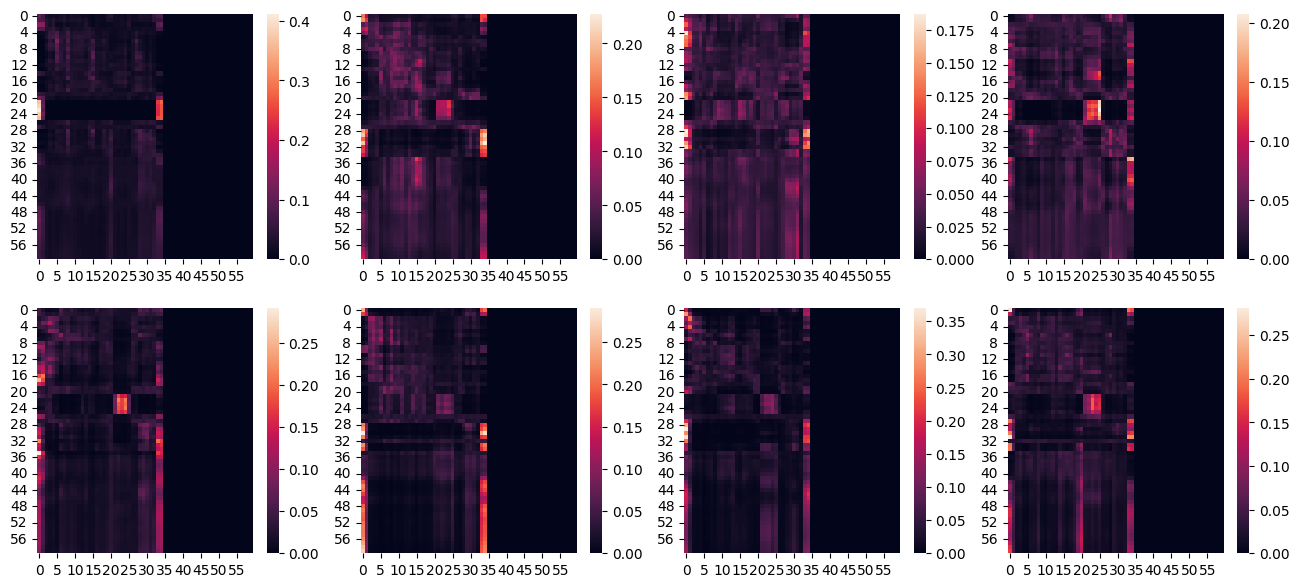


epoch : 2/10


  0%|          | 0/33622 [00:00<?, ?it/s]

TRAINING
mlm loss : 0.3671568862091785
VALIDATION
mlm loss : 0.347911484375
saved

true tokens : the coffee so bothering
pred tokens : the it i'm good
sample mlm loss : 0.4033085


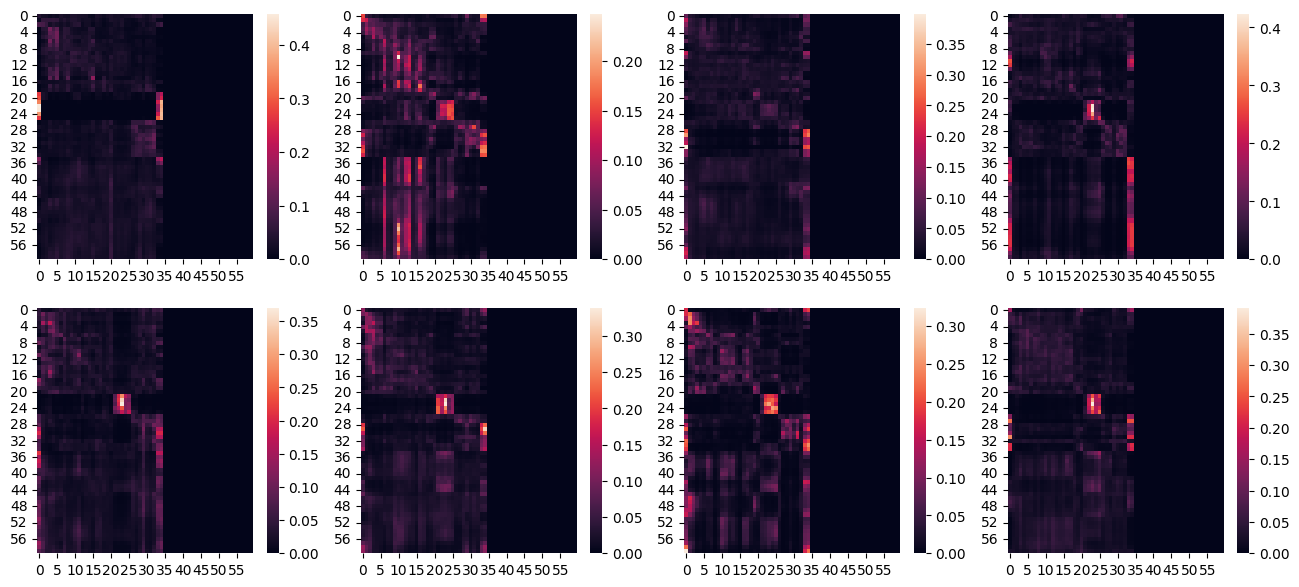


epoch : 3/10


  0%|          | 0/33622 [00:00<?, ?it/s]

TRAINING
mlm loss : 0.34356971556012433
VALIDATION
mlm loss : 0.331744921875
saved

true tokens : the coffee so bothering
pred tokens : the it i'm good
sample mlm loss : 0.38518035


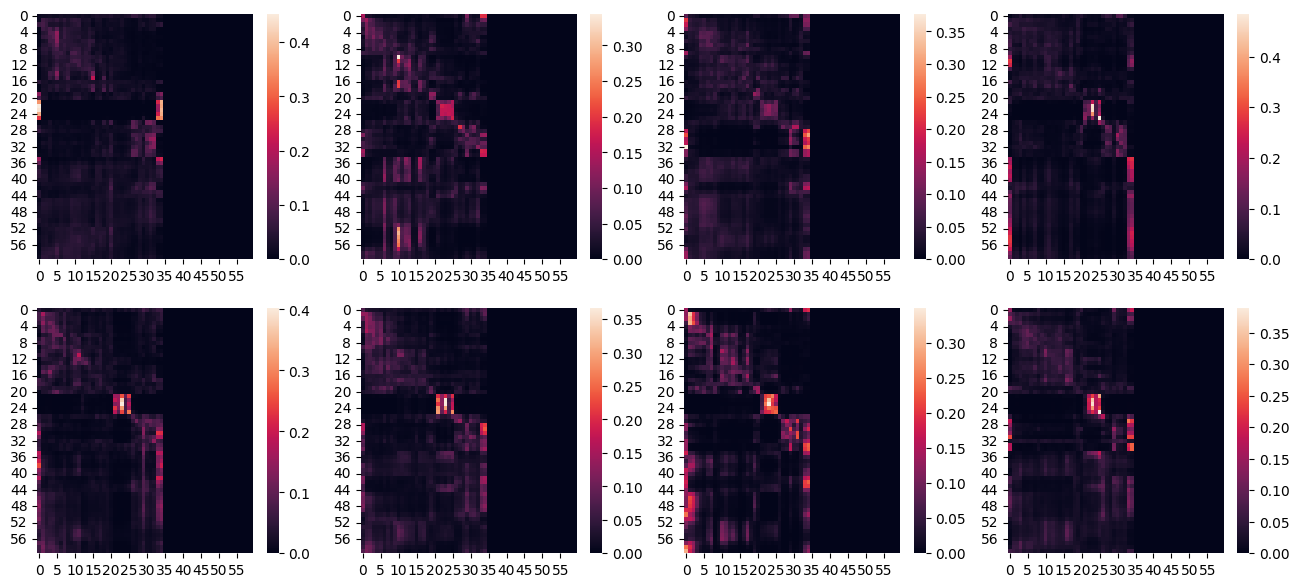


epoch : 4/10


  0%|          | 0/33622 [00:00<?, ?it/s]

TRAINING
mlm loss : 0.3303028488136488
VALIDATION
mlm loss : 0.321751484375
saved

true tokens : the coffee so bothering
pred tokens : the it i'm happy
sample mlm loss : 0.37625867


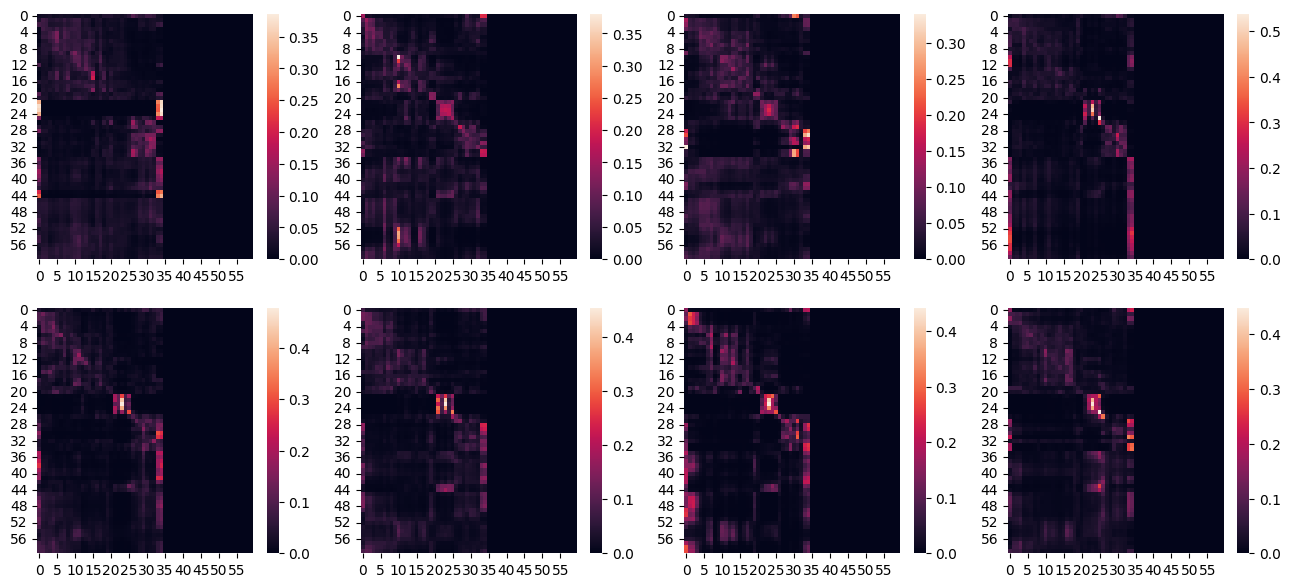


epoch : 5/10


  0%|          | 0/33622 [00:00<?, ?it/s]

TRAINING
mlm loss : 0.3208505359214205
VALIDATION
mlm loss : 0.31454923828125
saved

true tokens : the coffee so bothering
pred tokens : the it i'm sorry
sample mlm loss : 0.36951324


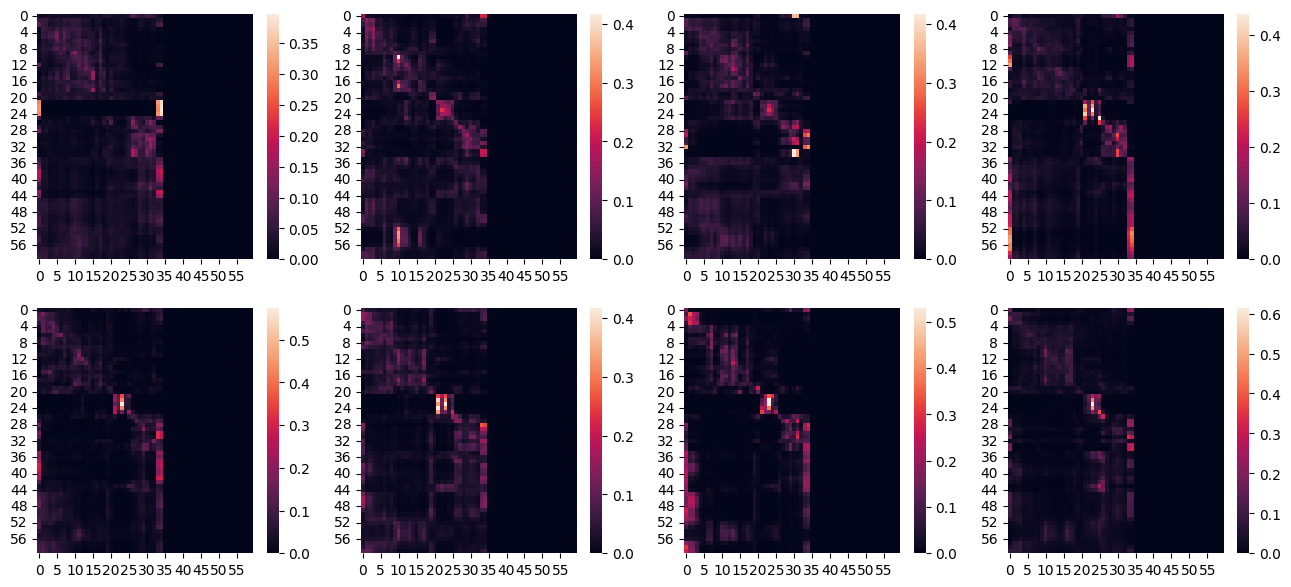


epoch : 6/10


  0%|          | 0/33622 [00:00<?, ?it/s]

TRAINING
mlm loss : 0.31336406988913507
VALIDATION
mlm loss : 0.30891875
saved

true tokens : the coffee so bothering
pred tokens : the it i'm sorry
sample mlm loss : 0.3647551


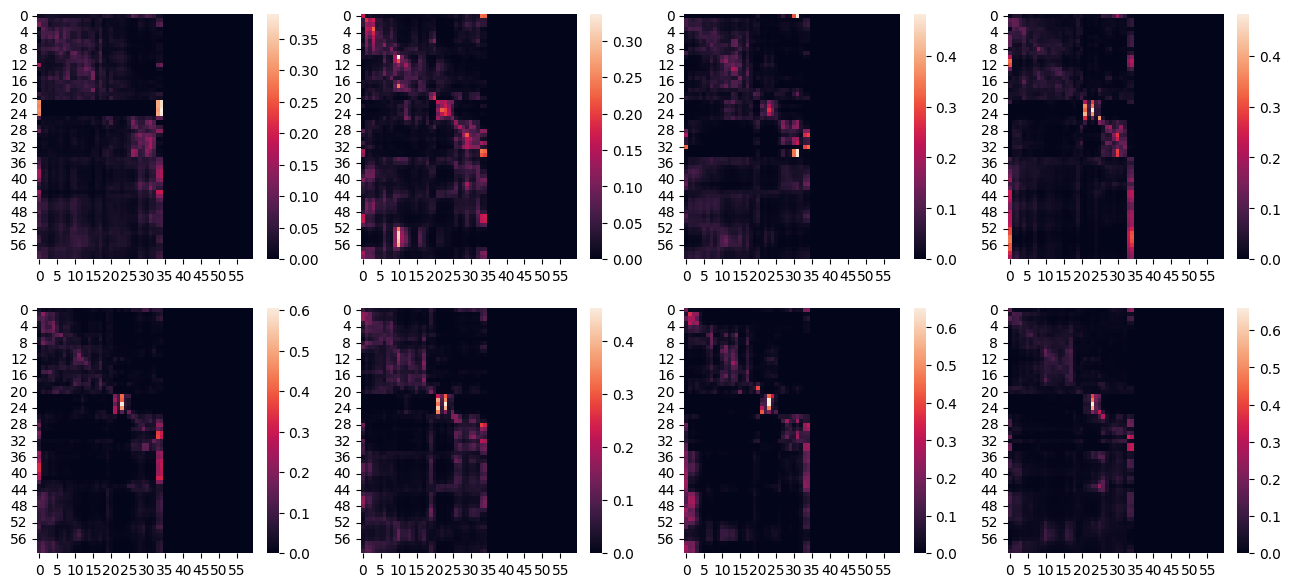


epoch : 7/10


  0%|          | 0/33622 [00:00<?, ?it/s]

TRAINING
mlm loss : 0.3071112466818601
VALIDATION
mlm loss : 0.30433263671875
saved

true tokens : the coffee so bothering
pred tokens : the it i'm happy
sample mlm loss : 0.36976573


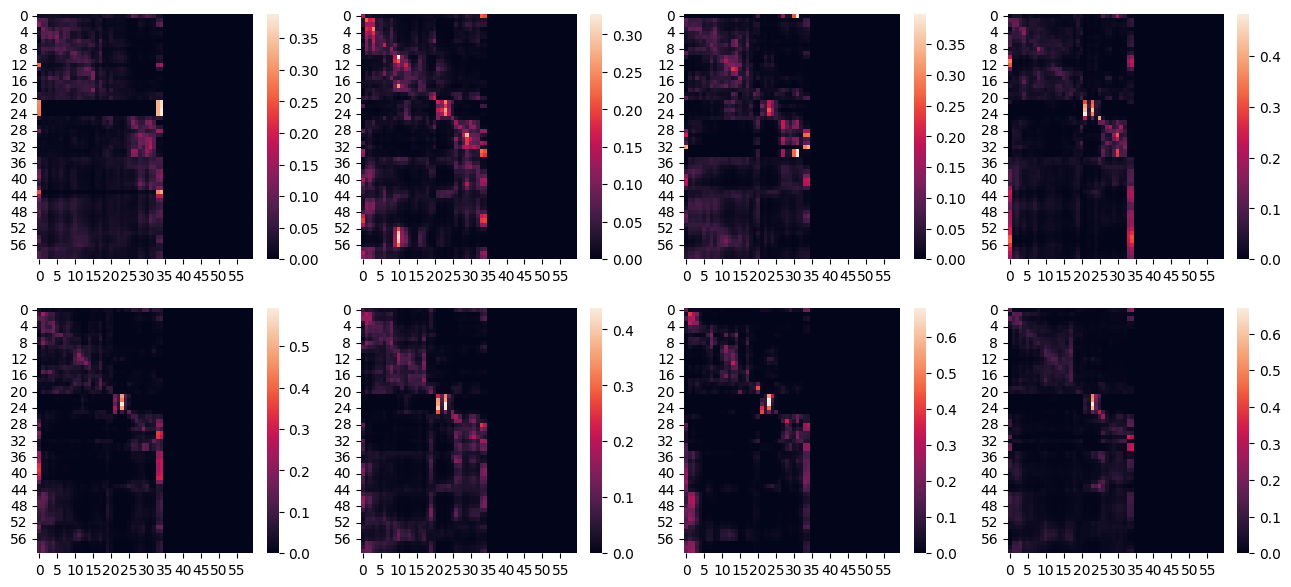


epoch : 8/10


  0%|          | 0/33622 [00:00<?, ?it/s]


KeyboardInterrupt



In [12]:
# train model for 10 epochs and visualize attention heads of final MHSA layer

epochs = 10

losses = {'train':{'mlm':[],'nsp':[],'mean':[]},
          'val':{'mlm':[],'nsp':[],'mean':[]}}

for e in range(epochs):
    print(f"epoch : {e+1}/{epochs}")
    mlm_loss = 0
    for i,(seq,mlm_y) in enumerate(tqdm(train)):
        lr = lr_scheduler(i+1)
        opt.learning_rate.assign(lr)
        mlm = train_step(seq,mlm_y)
        mlm_loss += mlm
            
    mlm_loss = mlm_loss.numpy() / (i + 1)
    
    print(f"TRAINING\nmlm loss : {mlm_loss}")
    
    losses['train']['mlm'].append(mlm_loss)
    
    mlm_loss = 0
    for i,(seq,mlm_y) in enumerate(val):
        mlm = test_step(seq,mlm_y)
        mlm_loss += mlm
        
        
    mlm_loss = mlm_loss.numpy() / (i + 1)
    
    print(f"VALIDATION\nmlm loss : {mlm_loss}")
    
    if e == 0 or min(losses['val']['mlm']) > mlm_loss:
        model.save_weights(f'best_weights/epoch{e+1}_ph1.h5')
        print('saved')
        
    losses['val']['mlm'].append(mlm_loss)
    print()
    
    predict_masked_tokens(test_mlm_x,test_mlm_y)
    
    _,ax = plt.subplots(2,4,figsize=(16,7))

    for i in range(2):
        for j in range(4):
            sb.heatmap(np.reshape(model.layers[1].layers[-1].mhsa.attention_scores.numpy()[0],
                                  (2,4,maxlen,maxlen))[i][j],ax=ax[i][j])
    plt.show()
    
    print()
                

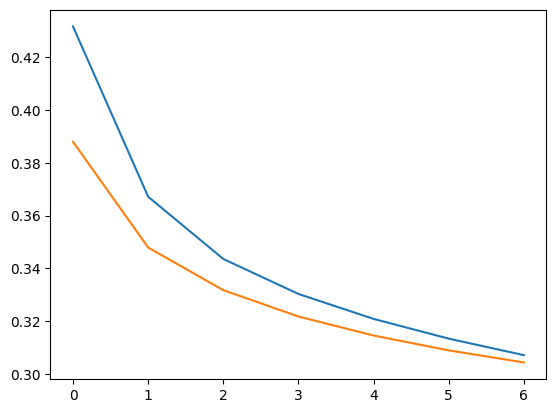

In [13]:
# visualize train and val logs

plt.plot(losses['train']['mlm'])
plt.plot(losses['val']['mlm'])

In [14]:
# load best weights

model.load_weights('best_weights/epoch6_ph1.h5')

In [15]:
# save weights for 2nd pretraining phase

weights = model.get_weights()

with open('pretrain_short_mlm.pkl','wb') as f:
    pickle.dump(weights,f)



In [16]:
# MLM model results

idx = np.random.randint(0,len(data['valid']['masked_seq']),10)

for i in idx:
    x = np.expand_dims(data['valid']['masked_seq'][i],0)
    y = data['valid']['seq'][i]
    pred = model(x,training=False)
    loss = mlm_loss_fn(y[np.newaxis:,],pred,sample_weight=x[0] == 1)
    pred = pred.numpy()[0]
    
    pred = np.argmax(pred,axis=-1)
    mseq = x[0].copy()
    mseq_idx = np.where(mseq == 1)[0]
    mseq[mseq_idx] = pred[mseq_idx]
    actual = data['valid']['seq'][i]
    
    print('masked :',' '.join([tokenizer.i2w[t] for t in x[0] if t>0]))
    print()
    print('actual :',' '.join([tokenizer.i2w[t] for t in actual if t>0]))
    print()
    print('pred :',' '.join([tokenizer.i2w[t] for t in mseq if t>0])+'\n')
    print(loss.numpy())
    
    print('---------------------------------')
    

masked : <cls> the film is set in a <mask> <mask> village in japan <mask> <mask> 19th century . according to tradition , once a person reaches the age of 70 <mask> or she must travel to a remote mountain to die of starvation , a practice known <mask> u ## basu ## te . <sep>

actual : <cls> the film is set in a small rural village in japan in the 19th century . according to tradition , once a person reaches the age of 70 he or she must travel to a remote mountain to die of starvation , a practice known as u ## basu ## te . <sep>

pred : <cls> the film is set in a small 's village in japan in a 19th century . according to tradition , once a person reaches the age of 70 's or she must travel to a remote mountain to die of starvation , a practice known for u ## basu ## te . <sep>

0.6952626
---------------------------------
masked : <cls> scrooge reluctantly gives his poor clerk bob <mask> me ## rv ## y ## n johns the day off <mask> pay <mask> but expects him back <mask> the earlier the ne

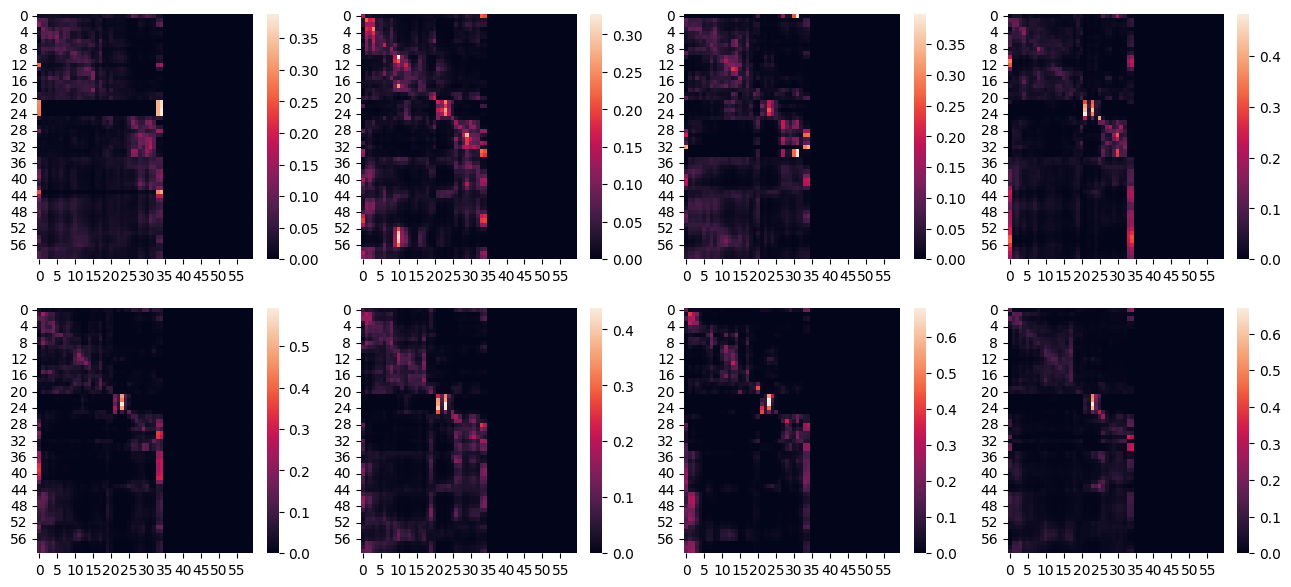

In [16]:
_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(model.layers[1].layers[4].mhsa.attention_scores.numpy()[0],
                              (2,4,maxlen,maxlen))[i][j],ax=ax[i][j])
        
plt.show()

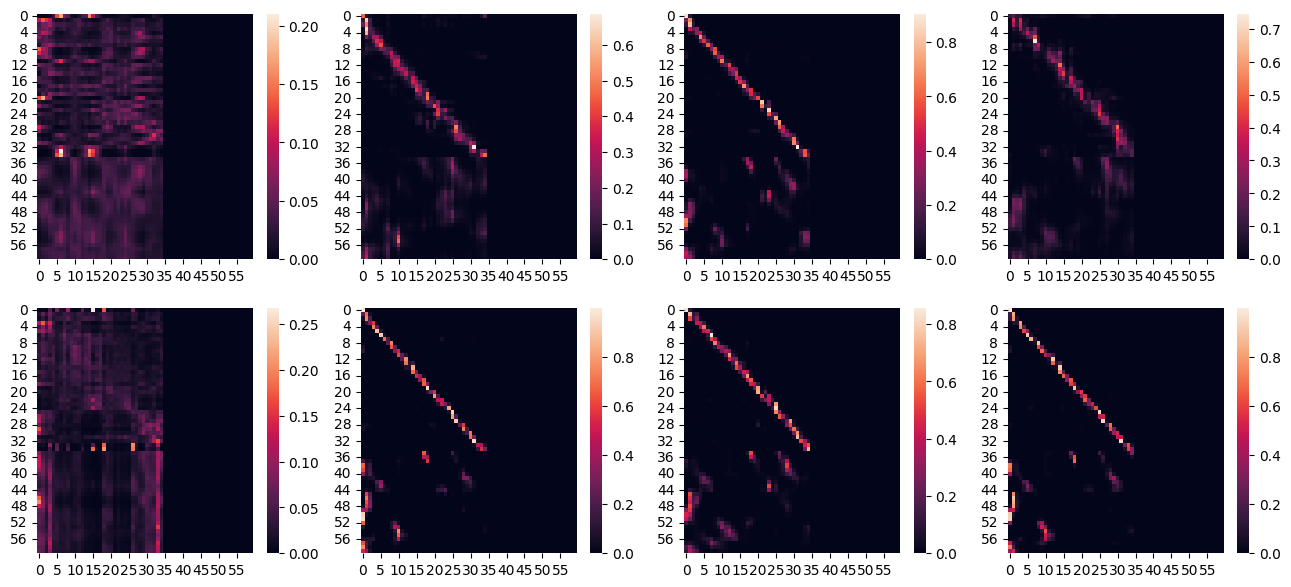

In [17]:
# plot attention weights

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(model.layers[1].layers[3].mhsa.attention_scores.numpy()[0],
                              (2,4,maxlen,maxlen))[i][j],ax=ax[i][j])
plt.show()

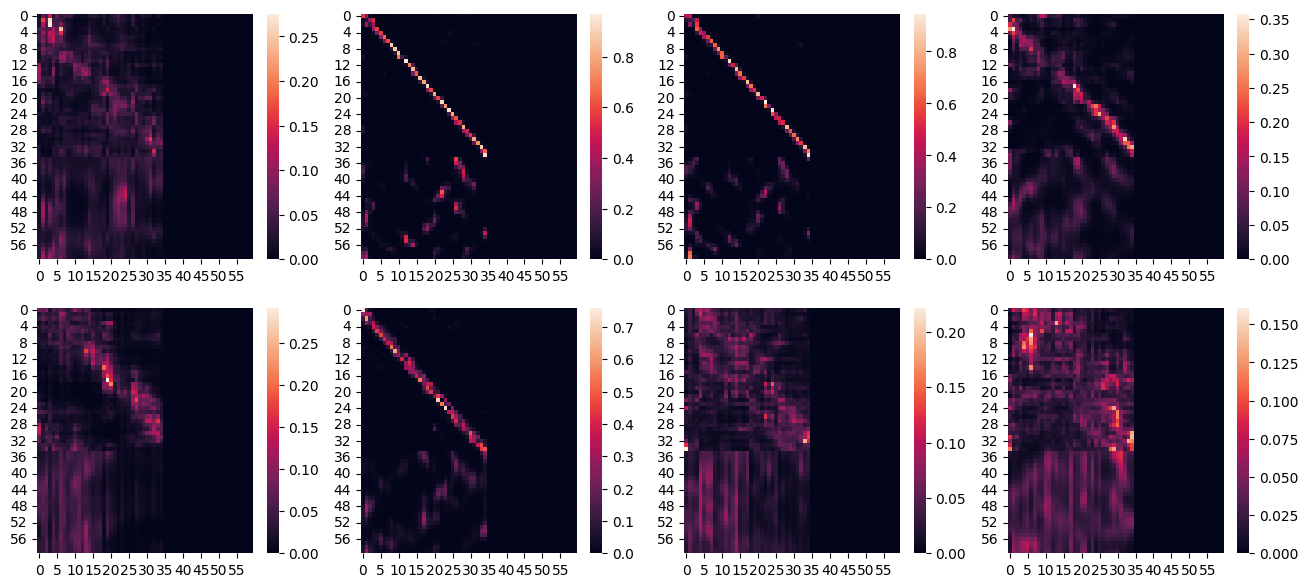

In [18]:
_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(model.layers[1].layers[2].mhsa.attention_scores.numpy()[0],
                              (2,4,maxlen,maxlen))[i][j],ax=ax[i][j])
        
plt.show()

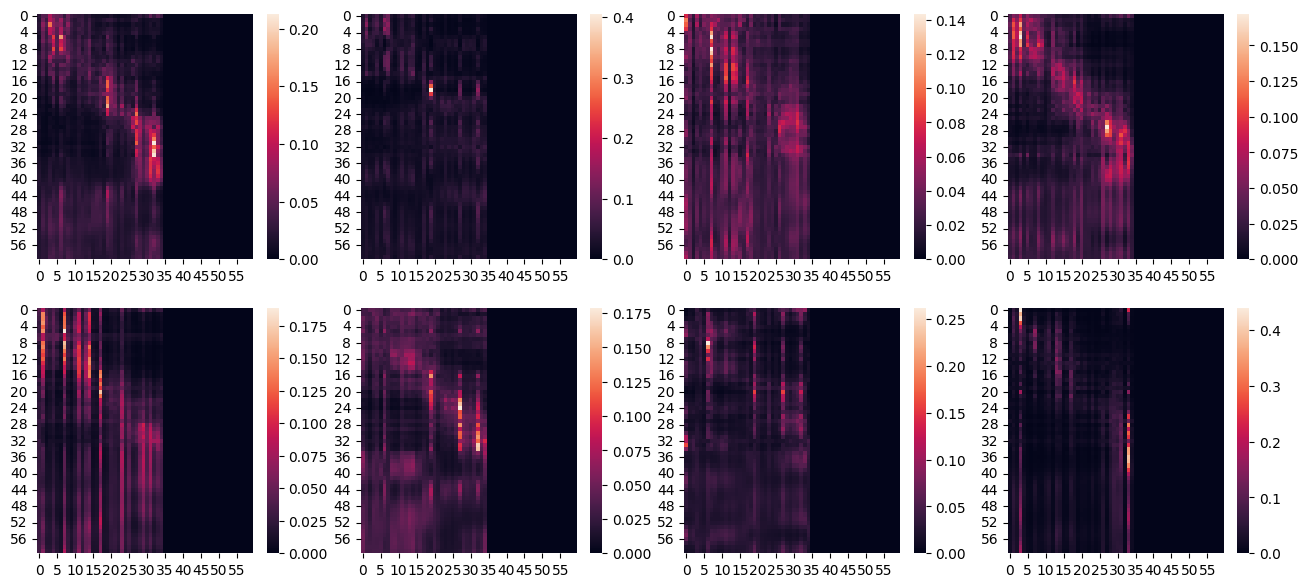

In [19]:
_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(model.layers[1].layers[1].mhsa.attention_scores.numpy()[0],
                              (2,4,maxlen,maxlen))[i][j],ax=ax[i][j])
        
plt.show()